In [167]:
from xgboost import XGBClassifier
import pprint
import operator
import collections
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score

In [185]:
file = '/Users/arpitjain/Desktop/changeClassifierResult/MSW_change_CC_FormalEMP&Lit_XGB_WO_2001.pkl'
tss = pickle.load(open(file,'rb'))
print('val_f1_score ',tss['xgBoost']['val_scores'])
print('train_f1_score ',tss['xgBoost']['train_scores'])

val_f1_score  [0.8540932093662523, 0.8520029408227838, 0.8465108307765462, 0.8441194466567913, 0.8199608726553729]
train_f1_score  [0.947472865749536, 0.9412138251691206, 0.9407693351684697, 0.9464269731695962, 0.9482139391350202]


In [179]:
# tss['xgBoost']['specs'][0]

In [176]:
n_estimators = tss['xgBoost']['specs'][0]['n_estimators']
max_depth = tss['xgBoost']['specs'][0]['max_depth']
learning_rate = tss['xgBoost']['specs'][0]['learning_rate']
objective = tss['xgBoost']['specs'][0]['objective']
booster = tss['xgBoost']['specs'][0]['booster']
gamma = tss['xgBoost']['specs'][0]['gamma']
min_child_weight = tss['xgBoost']['specs'][0]['min_child_weight']
max_delta_step = tss['xgBoost']['specs'][0]['max_delta_step']
subsample = tss['xgBoost']['specs'][0]['subsample']
colsample_bytree = tss['xgBoost']['specs'][0]['colsample_bytree']
colsample_bylevel = tss['xgBoost']['specs'][0]['colsample_bylevel']
colsample_bynode = tss['xgBoost']['specs'][0]['colsample_bynode']
reg_alpha = tss['xgBoost']['specs'][0]['reg_alpha']
reg_lambda = tss['xgBoost']['specs'][0]['reg_lambda']
scale_pos_weight = tss['xgBoost']['specs'][0]['scale_pos_weight']
base_score = tss['xgBoost']['specs'][0]['base_score']

n_splits = tss['xgBoost']['specs'][0]['kFold_splits']

print('                 ')
print('Re-Training again for calculating f1 and train scores')

xgbc = XGBClassifier(n_estimators=n_estimators, 
         max_depth=max_depth, learning_rate=learning_rate, 
         objective=objective, booster=booster,n_jobs=-1, 
         gamma=gamma, min_child_weight=min_child_weight, 
         max_delta_step=max_delta_step, subsample=subsample, 
         colsample_bytree=colsample_bytree, 
         colsample_bylevel=colsample_bylevel, colsample_bynode=colsample_bynode, 
         reg_alpha=reg_alpha, reg_lambda=reg_lambda, 
         scale_pos_weight=scale_pos_weight, base_score=base_score, random_state=0)

cv = KFold(n_splits=n_splits, shuffle=True)

                 
Re-Training again for calculating f1 and train scores


## Data 

In [177]:
ground_truth.head(2)

,census_code,MSW_change,MSW_2001,BF_change,BF_2001,CHH_change,CHH_2001,EMP_change,EMP_2001,MSL_change,MSL_2001,FC_change,FC_2001,ASSET_change,ASSET_2001,Formal_EMP_2001,LIT_2001
0,1,0,1,0,2,0,1,0,1,1,2,0,1,0,1,2,1
1,2,0,3,0,2,1,1,0,1,0,3,0,2,1,1,2,1


In [180]:
ground_truth = pd.read_csv("/Users/arpitjain/Downloads/SatPRo/2001_L7_data/ChangeClassifier/GroundTruth_ChangeClassifier.csv")
df = pd.read_csv("/Users/arpitjain/Downloads/SatPRo/2001_L7_data/ChangeClassifier/input_data/MSW_CC.csv")
data = ground_truth.merge(df, on='census_code', how='left')
data.dropna(inplace=True)
target = 'MSW_change'
feature_cols = ['Formal_EMP_2001','LIT_2001','MSW_2001','predictions_2003','predictions_2005', 'predictions_2007', 'predictions_2009','predictions_2011']

In [181]:
X = data[feature_cols].values
y = data[target].values

In [182]:
X.shape

(580, 8)

In [183]:
y.shape

(580,)

In [184]:
val_f1score = []
val_accscore = []
train_f1score = []
train_accscore = []
# f1score = []
# accscore = []
counter=0
for train_index, test_index in cv.split(X):
    print(counter)
    counter=counter+1
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    
    best_xgb = xgbc.fit(X_train, y_train)
    
#     prediction_2011 = best_xgb.predict(X_2011)
#     f1_weight = f1_score(y_2011, prediction_2011, average='weighted')
#     acc = accuracy_score(y_2011, prediction_2011)

#     f1score.append(f1_weight)
#     accscore.append(acc)

    predictions = best_xgb.predict(X_test)
    predictions_train = best_xgb.predict(X_train)

    f1_weight = f1_score(y_test, predictions, average='weighted')
    f1_weight_train = f1_score(y_train, predictions_train, average='weighted')
    acc = accuracy_score(y_test, predictions)
    acc_train = accuracy_score(y_train, predictions_train)

    val_f1score.append(f1_weight)
    train_f1score.append(f1_weight_train)
    val_accscore.append(acc)
    train_accscore.append(acc_train)

val_f1score = np.array(val_f1score).mean()
train_f1score = np.array(train_f1score).mean()
val_accscore = np.array(val_accscore).mean()
train_accscore = np.array(train_accscore).mean()
# f1score = np.array(f1score).mean()
# accscore = np.array(accscore).mean()
# print(f1score, accscore)
print(val_f1score, train_f1score, val_accscore, train_accscore)

0
1
2
3
4
0.8410762151737936 0.9459092103492267 0.8396551724137931 0.9459205249806137


In [163]:
from xgboost import plot_importance
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [164]:
# plot_importance(best_xgb,title='Asset-Gain',importance_type='gain',show_values=False, grid=False,height=0.3)
# plot_importance(best_xgb,title='Asset-Weight',importance_type='weight',show_values=False, grid=False,height=0.3)
# plot_importance(best_xgb,title='Asset-Total_Gain',importance_type='total_gain',show_values=False, grid=False,height=0.3)
# plot_importance(best_xgb,title='Asset-Cover',importance_type='cover',show_values=False, grid=False,height=0.3)
# plot_importance(best_xgb,title='Asset-Total_Cover',importance_type='total_cover',show_values=False, grid=False,height=0.3)
# pyplot.show()

In [165]:
# print('Gain')
# pprint.pprint(best_xgb.get_booster().get_score(importance_type= 'gain'))
# print('weight')
# pprint.pprint(best_xgb.get_booster().get_score(importance_type= 'weight'))
# print('cover')
# pprint.pprint(best_xgb.get_booster().get_score(importance_type= 'cover'))
# print('total_gain')
# pprint.pprint(best_xgb.get_booster().get_score(importance_type= 'total_gain'))
# print('total_cover')
# pprint.pprint(best_xgb.get_booster().get_score(importance_type= 'total_cover'))

Text(0.5, 1.0, 'MSW-Gain  -  Using FEMP & LIT')

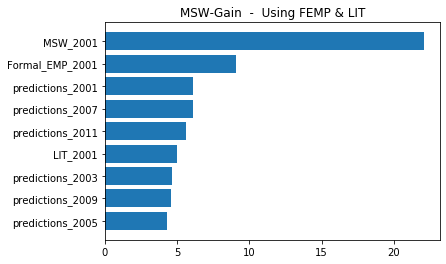

In [166]:
fcols = feature_cols
fi = best_xgb.get_booster().get_score(importance_type= 'gain')
fi_new = {}
for i in range(len(fcols)):
    key='f'+str(i)
    fi_new[fcols[i]] = fi[key]
sorted_x = sorted(fi_new.items(), key=operator.itemgetter(1))
sorted_dict = collections.OrderedDict(sorted_x)

plt.barh(range(len(sorted_dict)), list(sorted_dict.values()), align='center')
plt.yticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.title('MSW-Gain  -  Using FEMP & LIT')
# plt.savefig('MSL-Gain.jpg')

## 
The Gain implies the relative contribution of the corresponding 
feature to the model calculated by taking each feature’s contribution 
for each tree in the model. A higher value of this metric when compared to 
another feature implies it is more important for generating a prediction
-- The Gain is the most relevant attribute to interpret the relative importance of each feature

‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 
The idea is that before adding a new split on a feature X to the branch there was some 
wrongly classified elements, after adding the split on this feature, there are two new branches, 
and each of these branch is more accurate (one branch saying if your observation is on this branch 
then it should be classified as 1, and the other branch saying the exact opposite).

https://arxiv.org/abs/1706.06060


https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

Text(0.5, 1.0, 'MSL-Weight  -  Using FEMP & LIT')

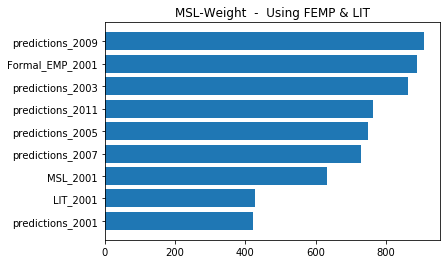

In [152]:
fcols = feature_cols
fi = best_xgb.get_booster().get_score(importance_type= 'weight')
fi_new = {}
for i in range(len(fcols)):
    key='f'+str(i)
    fi_new[fcols[i]] = fi[key]
sorted_x = sorted(fi_new.items(), key=operator.itemgetter(1))
sorted_dict = collections.OrderedDict(sorted_x)

plt.barh(range(len(sorted_dict)), list(sorted_dict.values()), align='center')
plt.yticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.title('MSL-Weight  -  Using FEMP & LIT')

##
weight, --> how many times a feature appears in a tree. 


Given that gender is well-populated and gives some clear indication of survival, 
it might not appear in many of the boosting rounds, thus driving it's weight lower.
